In [1]:
%matplotlib inline
import re
from pathlib import Path

import numpy as np

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
fids: list[FID1D] = []
for file in Path("../data/20230820-154517-Water-1H-rabi-nutation").glob("*.fid"):
    fids.append(FID1D.from_file(file))

# Extract pulse lengths from metadata
pattern = r"length=(.*)us,delay="
pulse_lengths_us = [float(re.search(pattern, str(fid.pulse))[1]) for fid in fids]

In [3]:
# Process
signal_strengths = []
for _i, fid in enumerate(fids):
    x, y = fid.simple_fft(phase_shift_kwargs=False)
    # TODO: Figure out why x is inverted?
    x = np.flip(x)
    y = np.flip(y)
    y = np.square(np.abs(y))
    integral = np.trapz(x=x, y=y)
    signal_strengths.append(integral)

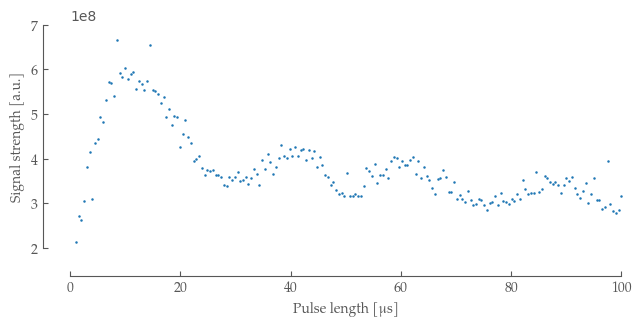

In [4]:
# Sort data by pulse lengths
pulse_lengths_us, signal_strengths = zip(
    *sorted(zip(pulse_lengths_us, signal_strengths))
)

# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    pulse_lengths_us,
    signal_strengths,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Signal strength [a.u.]")
axes.set_xlabel("Pulse length [μs]")

plot.format_axes(axes)

fig.savefig("rabi_nutation_raw.pdf")

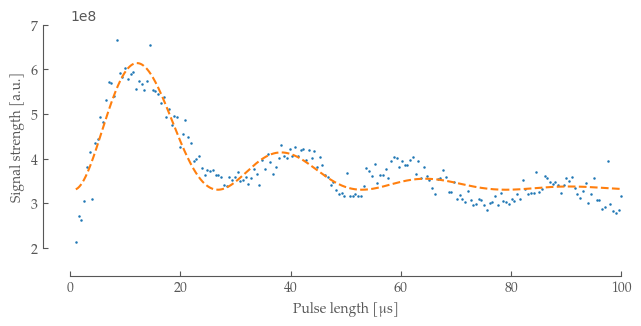

In [5]:
# Try to plot simple least squares fit
fit = process.fit_decaying_squared_sinusoid(pulse_lengths_us, signal_strengths)
pulse_lengths_us_fine = np.linspace(
    pulse_lengths_us[0], pulse_lengths_us[-1], len(pulse_lengths_us) * 10
)
axes.plot(
    pulse_lengths_us_fine,
    fit["function"](pulse_lengths_us_fine),
    linestyle="--",
)

# Save plot
fig.savefig("rabi_nutation_fit.pdf")
fig